In [1]:
from extract_data import get_data_from_directory
from preprocessing import preprocess
from takagi_sugeno_fnn import TS_FNN

import pandas as pd
import random

In [37]:
# data = list(get_data_from_directory('./decoded'))
# data = preprocess(data)
import json

with open('data_preprocessed.json', 'r', encoding="utf-8") as f:
    data = json.load(f)

In [3]:
pathology_diagnoses = ['H25', 'H26', 'H40']

for d in data:
    d['pathology'] = 1 \
        if any(d['main_diag'].startswith(p_d) for p_d in pathology_diagnoses) or \
           any(any(diag.startswith(p_d) for p_d in pathology_diagnoses) for diag in d['diag']) else 0
len(data)

4037

In [4]:
random.shuffle(data)
test_split = 0.1
split_index = int(test_split * len(data))
test_data, train_data = data[:split_index], data[split_index:]

In [5]:
dataframe = pd.DataFrame(data)
dataframe[:20]

,sex,main_diag,diag,diabetes,age,right_native,correction_right_sphere,correction_right_cylinder,corrected_right,left_native,correction_left_sphere,correction_left_cylinder,corrected_left,pathology
0,m,T15.0,[],False,61,0.5,0.00,0.0,0.5,0.5,0.00,0.00,0.5,0
1,f,H35.0,[H52.0],False,72,0.6,1.00,0.0,1.0,0.9,0.50,0.00,1.0,0
2,f,H40.1,[H25.1],False,78,0.2,-3.25,0.0,0.5,0.1,-3.50,0.00,0.5,1
3,m,H20.0,[H52.1],False,43,0.1,-2.00,0.0,1.0,0.0,-3.00,0.00,0.9,0
4,m,H02.1,"[H10.2, H25.0]",False,76,0.5,0.00,0.0,0.5,0.4,0.00,0.00,0.4,1
5,f,H35.0,[H52.4],True,83,0.9,0.00,0.0,0.9,0.9,0.00,0.00,0.9,0
6,f,H35.0,"[H26.8, E11.4]",True,72,0.0,0.00,0.0,0.0,0.4,0.00,0.00,0.4,1
7,m,H52.0,[H50.1],False,54,0.8,0.75,0.0,1.0,0.3,0.00,0.00,0.3,0
8,f,H43.3,"[H25.0, H10.2]",False,79,0.8,0.25,0.0,0.9,0.8,0.25,0.00,1.0,1
9,m,H35.9,"[H25.0, H35.0]",False,75,0.0,0.00,0.0,0.0,0.6,0.00,0.00,0.6,1


In [6]:
import numpy as np

def abs_max(a, b):
    if abs(a) > abs(b):
        return a
    else:
        return b

def vectorize(data):
    result = []
    for d in data:
        age = int(d['age'])

        result.append([age, d['pathology'], d['right_native'], d['corrected_right']])
        result.append([age, d['pathology'], d['left_native'], d['corrected_left']])
    return np.array(result)

def normalize(data):
    return [[d[0]/100, d[1], d[2], d[3]] for d in data]

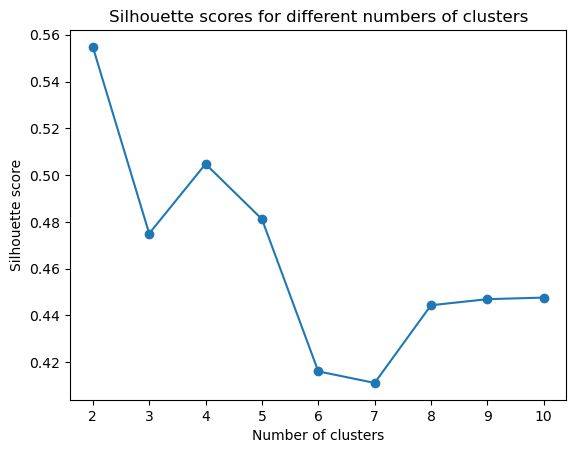

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette_scores = []
X = normalize(vectorize(data))

for n_clusters in range_n_clusters:
    # Create KMeans instance
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
    cluster_labels = kmeans.fit_predict(X)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotting the silhouette scores
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette scores for different numbers of clusters')
plt.xticks(range_n_clusters)
plt.show()

In [8]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto')
kmeans.fit(X)
kmeans.cluster_centers_

array([[4.82674294e-01, 1.83186799e-15, 6.86199499e-01, 9.05352163e-01],
       [7.23266129e-01, 1.00000000e+00, 3.95987903e-01, 5.61580645e-01]])

# Training FNN

In [25]:
vectorized_train_data = normalize(vectorize(train_data))
train_X = np.array([data[0:-1] for data in vectorized_train_data])
train_Y = np.array([data[-1] for data in vectorized_train_data])

ts_fnn = TS_FNN([2, 2, 2], [[0, 0, 0], [1, 1, 1]])
ts_fnn.init_mu_parameters([[0.48, 0.72], [0., 1.], [0.68, 0.39]])
ts_fnn.init_sigma_parameters([[0.2, 0.2], [0.2, 0.2], [0.2, 0.2]])

ts_fnn.fit(train_X, train_Y, epochs=20, learning_rate=0.0001, gradient_accumulation_step=64)

Iteration 1 Epoch 0 loss 21417.12033
Iteration 2 Epoch 0 loss 16303.855512789838
Iteration 3 Epoch 0 loss 13372.981421401495
Iteration 4 Epoch 0 loss 9522.5521768093
Iteration 5 Epoch 0 loss 5873.748985738919
Iteration 6 Epoch 0 loss 5787.3997773988995
Iteration 7 Epoch 0 loss 4571.373284604619
Iteration 8 Epoch 0 loss 3888.7665172451025
Iteration 9 Epoch 0 loss 2302.7759068536325
Iteration 10 Epoch 0 loss 2828.8448618052144
Iteration 11 Epoch 0 loss 2208.053442540876
Iteration 12 Epoch 0 loss 1648.0046706351752
Iteration 13 Epoch 0 loss 1318.797180524748
Iteration 14 Epoch 0 loss 979.0517644695332
Iteration 15 Epoch 0 loss 966.9492494747071
Iteration 16 Epoch 0 loss 890.8299735782512
Iteration 17 Epoch 0 loss 612.6612887828112
Iteration 18 Epoch 0 loss 637.3498744709779
Iteration 19 Epoch 0 loss 673.4591874962084
Iteration 20 Epoch 0 loss 535.067178710371
Iteration 21 Epoch 0 loss 656.5010137219969
Iteration 22 Epoch 0 loss 585.9828421747717
Iteration 23 Epoch 0 loss 517.4668941883237

In [30]:
ts_fnn.parameters

(array([[ 0.4342307 ,  0.69803584],
        [-0.00239687,  0.98158925],
        [ 0.60691499,  0.38960826]]),
 array([[0.12237515, 0.25533553],
        [0.18668581, 0.3657726 ],
        [0.24502824, 0.20540369]]),
 array([0.84625016, 0.09931292]),
 [array([-0.03368215,  0.99533472,  0.17189214]),
  array([0.0516865 , 0.08678812, 0.87249658])])

# Testing

In [23]:
from testing import r_squared_test

In [29]:
vectorized_test_data = normalize(vectorize(test_data))
test_X = np.array([data[0:-1] for data in vectorized_test_data])
test_Y = np.array([data[-1] for data in vectorized_test_data])
prediction_fun = lambda x: ts_fnn.predict(x)

r_squared_test(prediction_fun, test_X, test_Y)

0.605481751696541

# Comparisson with linear regression

In [17]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(train_X, train_Y)

r_squared_test(lambda x: reg.predict([x])[0], test_X, test_Y)

0.5194092427619731